In [1]:
import pandas as pd
from category_encoders import BinaryEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score,accuracy_score,recall_score,f1_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler, \
    PowerTransformer, QuantileTransformer,LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud as WordCloud
import numpy as np
from collections import Counter
from datetime import datetime

In [2]:
def one_hot_encoder(df, var):
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(df[[var]])
    df = df.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))
    df[var].to_csv('encoded_data.csv', index=False)
    # print(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head())
    return df

In [3]:
def label_encoder(df, var):
    label_encoder = LabelEncoder()
    df[var] = label_encoder.fit_transform(df[var])
    return df

In [4]:
def frequency_encoder(df, var):
    # grouping by frequency
    fq = df.groupby(var).size() / len(df)
    # mapping values to dataframe
    df.loc[:, "{}_freq_encode".format(var)] = df[var].map(fq)
    # drop original column.
    df = df.drop([var], axis=1)
    return df

In [5]:
def ms_mode(X_train, X_test, var):
    # Điền giá trị xuất hiện nhiều nhất vào các ô trống (Model Imputation)
    most_common = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(most_common)
    X_test[var] = X_test[var].fillna(most_common)
    return X_train, X_test

In [6]:
# def split_string_office(train, test,var):
#     # Xử lý đặc trưng "WorldwideBox Office" để chuyển đổi thành số nguyên
#     train[var] = [float(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in train[var]]
#     # train[var] = train[var].str.replace('$', '').str.replace(',', '').astype(float)
#     test[var] = [float(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in test[var]]
#     # test[var] = test[var].str.replace('$', '').str.replace(',', '').astype(float)

#     return train, test

def split_string_office(data,var):
    data[var]=[int(rt.replace('$','').replace(',','')) if rt is not np.nan else np.nan for rt in data[var]]
    return data


In [7]:
# def split_string_time(X_train, X_test):
#     # Xử lý đặc trưng "Running Time" để chỉ giữ lại số phút
#     X_train['Running Time'] = [int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in X_train['Running Time']]
#     X_test['Running Time'] = [int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in X_test['Running Time']]
#     return X_train, X_test

def split_string_time(data):
    data['Running Time']=[int(rt.split(' ')[0]) if rt is not np.nan else np.nan for rt in data['Running Time']]
    return data

In [8]:
def date(x):
    x=str(x)
    date_string=x.replace('th,','').replace('st,','').replace('nd,','').replace('rd,','').replace(' ','')
    date_obj=datetime.strptime(date_string,'%B%d%Y')
    return date_obj

# def split_string_date(X_train,X_test):
#     X_train['Year Releases']=X_train['Domestic Releases'].apply(lambda x: date(x).year if x is not np.nan else np.nan)
#     X_train['Day Releases']=X_train['Domestic Releases'].apply(lambda x: date(x).weekday() if x is not np.nan else np.nan)
#     X_train['Month Releases']=X_train['Domestic Releases'].apply(lambda x: date(x).month if x is not np.nan else np.nan)

#     X_test['Year Releases']=X_test['Domestic Releases'].apply(lambda x: date(x).year if x is not np.nan else np.nan)
#     X_test['Day Releases']=X_test['Domestic Releases'].apply(lambda x: date(x).weekday() if x is not np.nan else np.nan)
#     X_test['Month Releases']=X_test['Domestic Releases'].apply(lambda x: date(x).month if x is not np.nan else np.nan)

#     return X_train,X_test

def split_string_date(data):
    data['Day Releases']=data['Date Releases'].apply(lambda x: date(x).weekday() if x is not np.nan else np.nan)
    data['Month Releases']=data['Date Releases'].apply(lambda x: date(x).month if x is not np.nan else np.nan)
    
    return data



In [9]:
def handler_outlier(df_train, df_test, var):
    IQR = df_train[var].quantile(0.75) - df_train[var].quantile(0.25)
    lower_boundary = df_train[var].quantile(0.25) - (IQR * 3)
    uppper_boundary = df_train[var].quantile(0.75) + (IQR * 3)

    df_train.loc[df_train[var] >= uppper_boundary, var] = uppper_boundary
    df_test.loc[df_test[var] >= uppper_boundary, var] = uppper_boundary
    return df_train, df_test

In [10]:
def minmax_scaler(df):
    new_df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df

In [11]:
def robust_scaler(df):
    new_df = pd.DataFrame(RobustScaler(quantile_range=(25, 75)).fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [12]:
def standard_scaler(df):
    new_df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [13]:
def maxabs_scaler(df):
    new_df = pd.DataFrame(MaxAbsScaler().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [14]:
def power_transformer(df):
    new_df = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [15]:
def quantile_transformer(df):
    new_df = pd.DataFrame(QuantileTransformer(n_quantiles=len(df), output_distribution='normal').fit_transform(df))
    return new_df


In [16]:
def normalizer(df):
    new_df = pd.DataFrame(Normalizer().fit_transform(df), columns=df.columns, index=df.index)
    return new_df


In [17]:
def normal_data(X_train, X_test, type):
    if type == 'Unscaled':
        pass
    elif type == 'Standard':
        X_train = standard_scaler(X_train)
        X_test = standard_scaler(X_test)
    elif type == 'MinMax':
        X_train = minmax_scaler(X_train)
        X_test = minmax_scaler(X_test)
    elif type == 'MaxAbs':
        X_train = maxabs_scaler(X_train)
        X_test = maxabs_scaler(X_test)
    elif type == 'Robust':
        X_train = robust_scaler(X_train)
        X_test = robust_scaler(X_test)
    elif type == 'PowerTransformer':
        X_train = power_transformer(X_train)
        X_test = power_transformer(X_test)
    elif type == 'QuantileTransformer':
        X_train = quantile_transformer(X_train)
        X_test = quantile_transformer(X_test)
    elif type == 'Normalizer':
        X_train = normalizer(X_train)
        X_test = normalizer(X_test)
    return X_train, X_test

In [18]:
smallDS_path = 'SmallDS_raw2.csv'
bigDS_path = 'BigDS_raw1.csv'

df_small = pd.read_csv(smallDS_path)
df_big = pd.read_csv(bigDS_path)

data = df_small.copy()

split_string_office(data,'WorldwideBox Office')
split_string_office(data,'Production Budget')
split_string_time(data)
split_string_date(data)

# data.info()
df_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      10000 non-null  int64 
 1   Rank                            10000 non-null  int64 
 2   Year                            10000 non-null  int64 
 3   Movie                           10000 non-null  object
 4   WorldwideBox Office             10000 non-null  object
 5   Production Budget               4707 non-null   object
 6   Date Releases                   5290 non-null   object
 7   MPAA                            7490 non-null   object
 8   Running Time                    8569 non-null   object
 9   Franchise                       1964 non-null   object
 10  Genre                           9511 non-null   object
 11  Creative Type                   9261 non-null   object
 12  Production/Financing Companies  4671 non-null  

In [19]:
# y_train, y_test = split_string_office(y_train, y_test,'WorldwideBox Office')

# X_train,X_test=split_string_office(X_train,X_test,'Production Budget')
# X_train, X_test = split_string_time(X_train, X_test)
# X_train,X_test=split_string_date(X_train,X_test)


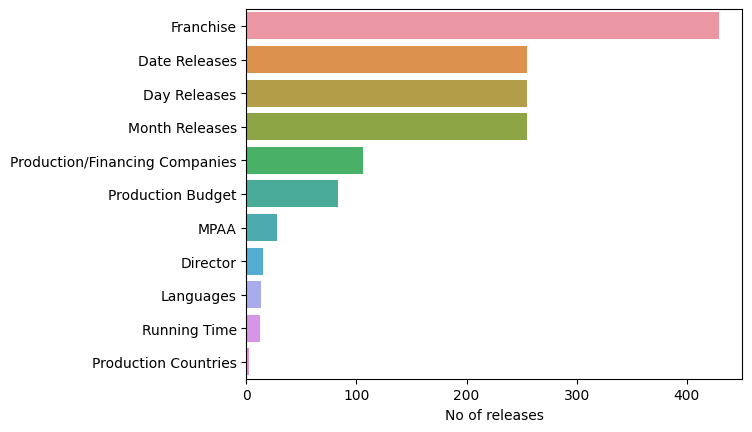

In [20]:
# plt.figure(figsize=(10,10))
missing=data.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing[:11],y=missing[:11].index)
plt.style.use('dark_background')
plt.xlabel('No of releases')
plt.show()

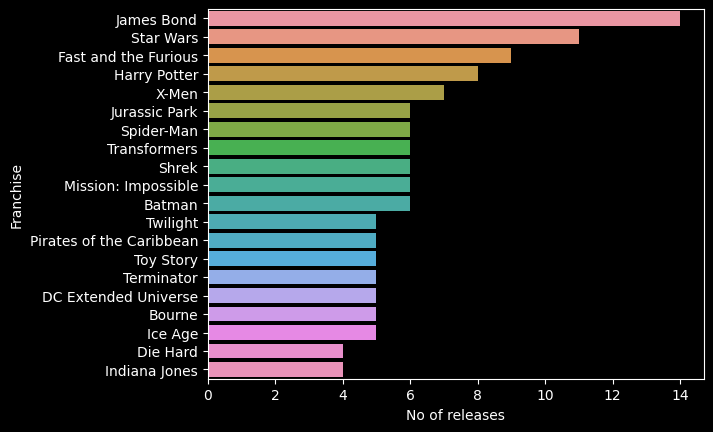

In [21]:
list_franchise=data.groupby(['Franchise']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_franchise[:20],y='Franchise',x='No of releases')
plt.show()

<Axes: xlabel='No of releases', ylabel='Production/Financing Companies'>

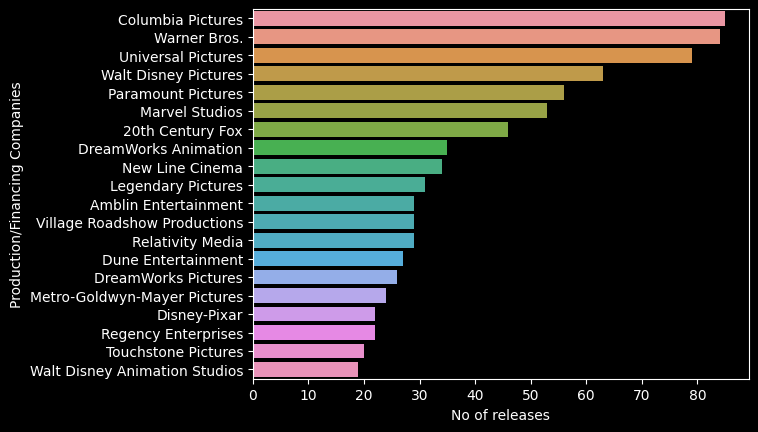

In [22]:
data['Production/Financing Companies']=data['Production/Financing Companies'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_companies=pd.DataFrame(Counter([i for j in data['Production/Financing Companies'] for i in j]).most_common(),columns=['Production/Financing Companies','No of releases'])
sns.barplot(data=list_companies[:20],y='Production/Financing Companies',x='No of releases')

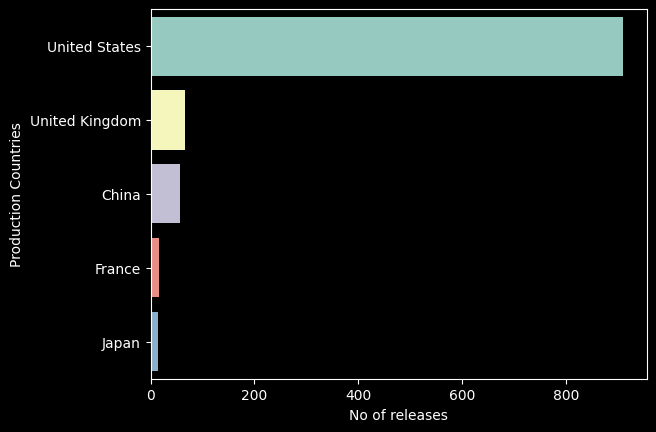

In [23]:
data['Production Countries']=data['Production Countries'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_countries=pd.DataFrame(Counter([i for j in data['Production Countries'] for i in j]).most_common(),columns=['Production Countries','No of releases'])
sns.barplot(data=list_countries[:5],y='Production Countries',x='No of releases')
plt.show()

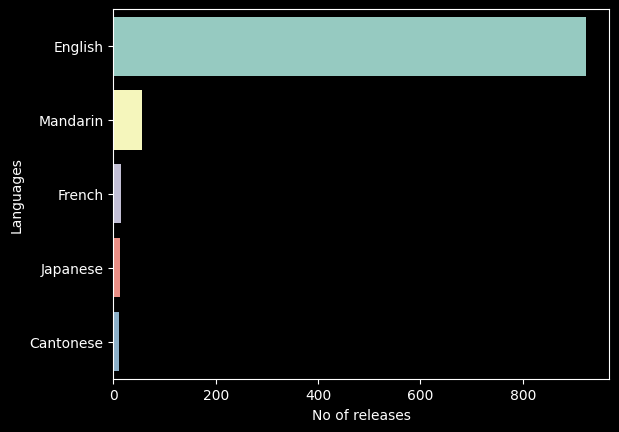

In [24]:
data['Languages']=data['Languages'].apply(lambda x:[i for i in x.split(', ')] if x is not np.nan else [] )
list_languages=pd.DataFrame(Counter([i for j in data['Languages'] for i in j]).most_common(),columns=['Languages','No of releases'])
sns.barplot(data=list_languages[:5],y='Languages',x='No of releases')
plt.show()


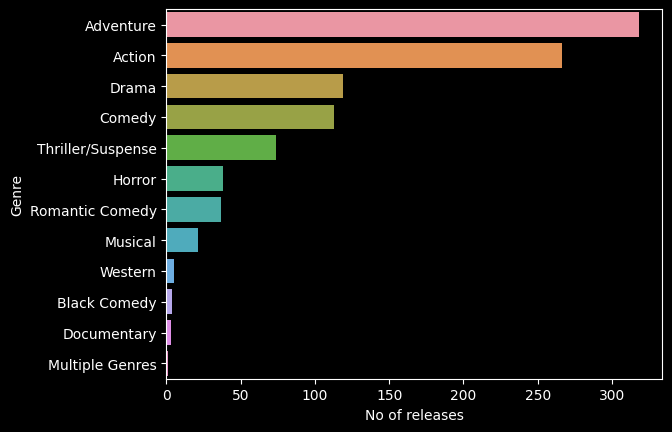

In [25]:
list_genre=data.groupby(['Genre']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_genre,y='Genre',x='No of releases')
plt.show()

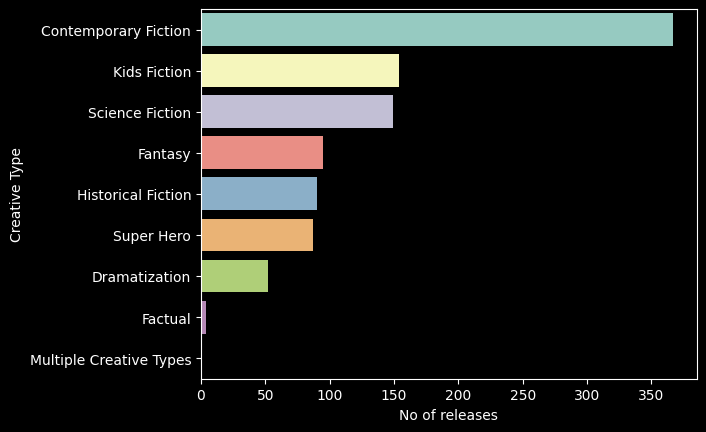

In [26]:
list_creative_type=data.groupby(['Creative Type']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_creative_type,y='Creative Type',x='No of releases')
plt.show()

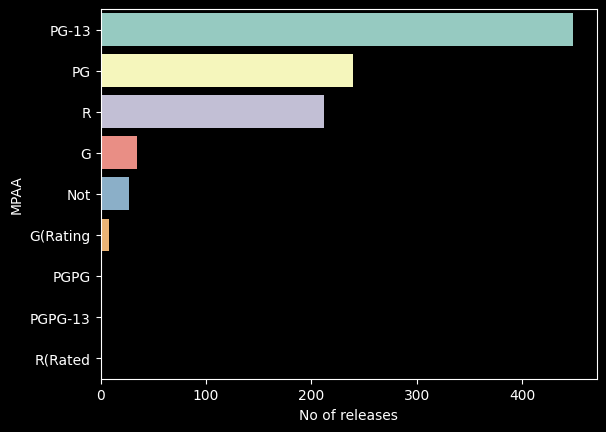

In [27]:
list_mpaa=data.groupby(['MPAA']).size().reset_index(name='No of releases').sort_values(ascending=False,by='No of releases')
sns.barplot(data=list_mpaa,y='MPAA',x='No of releases')
plt.show()

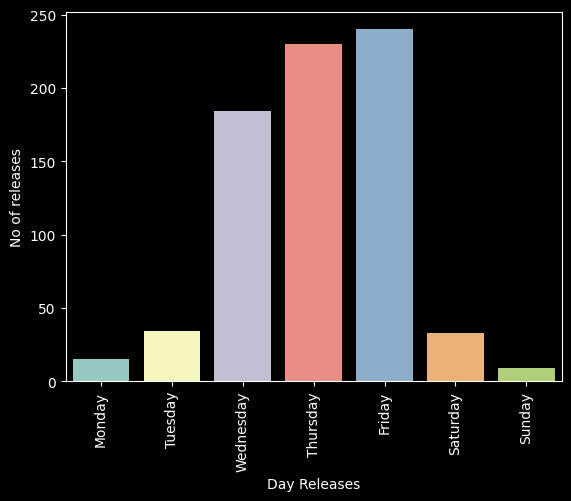

In [28]:
list_day=data.groupby(['Day Releases']).size().reset_index(name='No of releases')
sns.barplot(data=list_day,x='Day Releases',y='No of releases')
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')
plt.show()

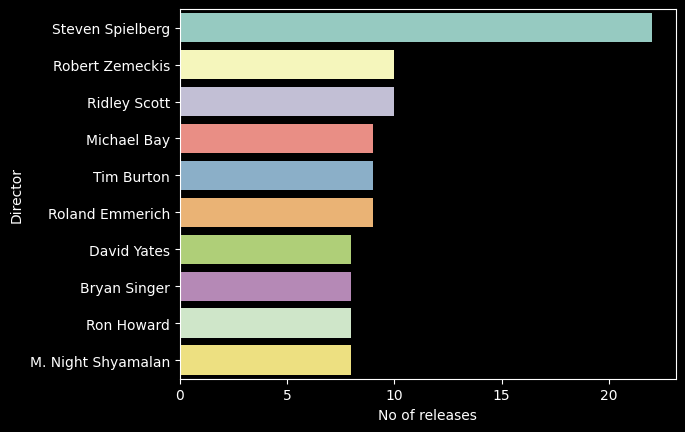

In [29]:
data['Director']=data['Director'].apply(lambda x:[i for i in x.split(',')] if x is not np.nan else [] )
list_director=pd.DataFrame(Counter([i for j in data['Director'] for i in j]).most_common(),columns=['Director','No of releases'])
sns.barplot(data=list_director[:10],y='Director',x='No of releases')
plt.show()

In [30]:

X = data.copy()
y =data[['WorldwideBox Office']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [31]:

def list_top(df,var,list,top):
    list_total=[]
    for i in list[var]:
        total=0
        for j in df.index:
            if df.loc[j,var] is np.nan:
                total+=0
            else:
                total+=df.loc[j,'WorldwideBox Office'] if (i in df.loc[j,var]) else 0
        list_total.append(total)   
    list['WorldwideBox Office']=list_total
    return list[:top].copy().sort_values(by='WorldwideBox Office',ascending=False)


In [32]:

top100_companies=list_top(X_train,'Production/Financing Companies',list_companies,100)
top100_director=list_top(X_train,'Director',list_director,100)

top15_franchise=list_top(X_train,'Franchise',list_franchise,15)


/tmp/ipykernel_14881/4017262084.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')


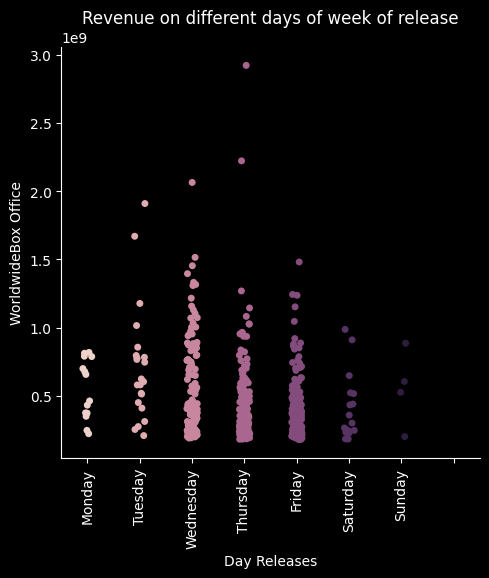

In [33]:
# plt.figure(figsize=(10,10))
sns.catplot(x=X_train['Day Releases'],y=y_train['WorldwideBox Office'], hue=X_train['Day Releases'])
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='vertical')
plt.title('Revenue on different days of week of release')
plt.show()

In [34]:
# y_train['WorldwideBox Office']=np.log1p(y_train['WorldwideBox Office'])
# X_train['Production Budget']=np.log1p(X_train['Production Budget'])

/tmp/ipykernel_14881/1485123138.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July',


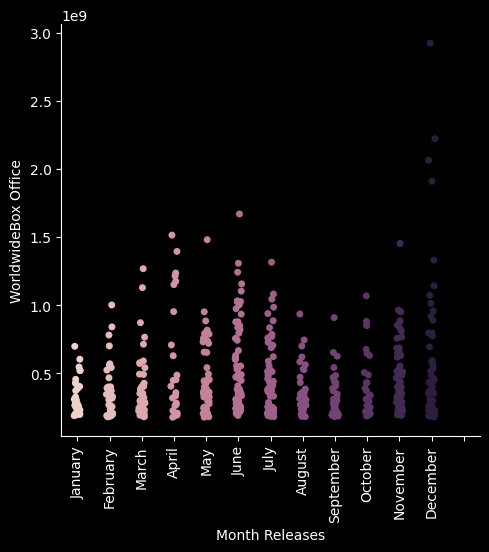

In [35]:
sns.catplot(x=X_train['Month Releases'],y=y_train['WorldwideBox Office'], hue=X_train['Month Releases'])
plt.gca().set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December'],rotation='vertical')
plt.show()

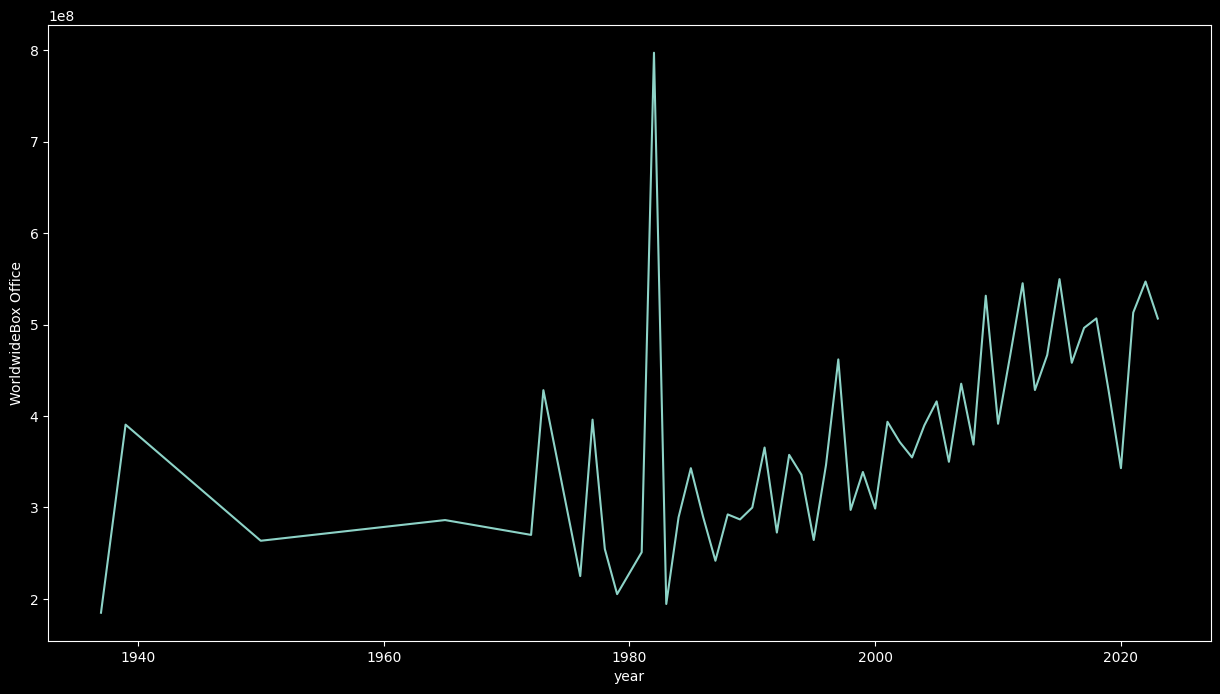

In [36]:

plt.figure(figsize=(15,8))
yearly=y_train.groupby(X_train['Year'])['WorldwideBox Office'].agg('mean')
plt.plot(yearly.index,yearly)
plt.xlabel('year')
plt.ylabel("WorldwideBox Office")
plt.savefig('fig')

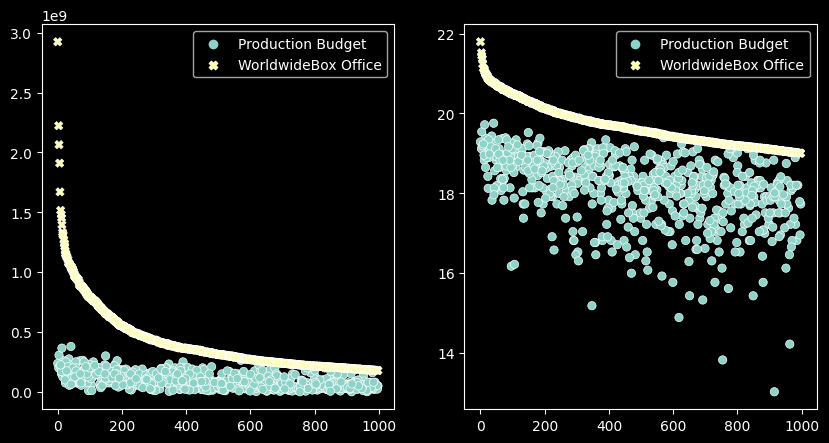

In [37]:

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(data=[X_train['Production Budget'],y_train['WorldwideBox Office']])
plt.subplot(1,2,2)
sns.scatterplot(data=[np.log1p(X_train['Production Budget']),np.log1p(y_train['WorldwideBox Office'])])
plt.show()


In [38]:
# def binary_encoder(df, var):
#     encoder = BinaryEncoder(cols=[var])
#     newdata = encoder.fit_transform(df[var])
#     df = pd.concat([df, newdata], axis=1)
#     # dropping old column
#     df = df.drop([var], axis=1)
#     return df

def binary_encoder(df, var , list):
    for i in list[var]:
        new_data=[]
        for j in df[var]:
            new_data.append(1 if i in j else 0)
        df[var+'_'+i]=new_data
    df.drop(columns=var)
    return df

def is_holiday_month(df):
    df['holiday_month']=[1 if i in [5,6,7,11,12] else np.nan if i is np.nan else 0 for i in df['Month Releases']]
    return df

def original_isEnglish(df):
    df['origin_isEnglish']=[1 if 'English' in i else 0 for i in df['Languages']]
    df.drop(columns='Languages')
    return df 

def top_companies(df):
    list=[]
    for i in df['Production/Financing Companies']:
        val=1 if any(x in i for x in top100_companies['Production/Financing Companies']) else np.nan if i is np.nan else 0
        list.append(val)
    df['topCompanies']=list
    return df

def isTop_director(df):
    list=[]
    for i in df['Director']:
        val=1 if any(x in i for x in top100_director['Director']) else np.nan if i is np.nan else 0
        list.append(val)
    df['topDirector']=list
    return df

def top_franchise(df):
    list=[]
    for i in df['Franchise']:
        val=1 if  i in top15_franchise['Franchise'] else 0 if i is np.nan else 2
        list.append(val)
    df['topFranchise']=list
    return df


In [39]:
X_train=top_companies(X_train)
X_train=isTop_director(X_train)
X_train=is_holiday_month(X_train)
X_train=original_isEnglish(X_train)
X_train=top_franchise(X_train)

X_test=top_companies(X_test)
X_test=isTop_director(X_test)
X_test=is_holiday_month(X_test)
X_test=original_isEnglish(X_test)
X_test=top_franchise(X_test)

In [40]:

X_train, X_test = ms_mode(X_train, X_test, 'Running Time')
# X_train, X_test = ms_mode(X_train, X_test, 'Director')
# X_train, X_test = ms_mode(X_train, X_test, 'Production/Financing Companies')
X_train, X_test = ms_mode(X_train, X_test, 'Genre')
X_train, X_test = ms_mode(X_train,X_test,'Production Budget')
# X_train, X_test = ms_mode(X_train,X_test,'Production Countries')
# X_train, X_test = ms_mode(X_train,X_test,'Languages')
X_train, X_test = ms_mode(X_train,X_test,'Creative Type')
X_train, X_test = ms_mode(X_train,X_test,'Day Releases')
X_train, X_test = ms_mode(X_train,X_test,'Month Releases')
X_train,X_test=ms_mode(X_train,X_test,'MPAA')

In [41]:
X_train = label_encoder(X_train, "Genre")
# X_train = binary_encoder(X_train, "Production/Financing Companies",list_companies)
# X_train = binary_encoder(X_train, "Director",list_director)
X_train = label_encoder(X_train, "Creative Type")
# X_train = binary_encoder(X_train, "Production Countries",list_countries)
X_train=label_encoder(X_train,"MPAA")

X_test = label_encoder(X_test, "Genre")
# X_test = binary_encoder(X_test, "Production/Financing Companies",list_companies)
# X_test = binary_encoder(X_test, "Director",list_director)
X_test = label_encoder(X_test, "Creative Type")
# X_test = binary_encoder(X_test, "Production Countries",list_countries)
X_test=label_encoder(X_test,"MPAA")



In [42]:
X_train=X_train[['Production Budget','MPAA','Running Time','Genre','Creative Type','topCompanies','topDirector','holiday_month','origin_isEnglish','topFranchise']]
X_test=X_test[['Production Budget','MPAA','Running Time','Genre','Creative Type','topCompanies','topDirector','holiday_month','origin_isEnglish','topFranchise']]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 105 to 684
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Production Budget  700 non-null    float64
 1   MPAA               700 non-null    int64  
 2   Running Time       700 non-null    float64
 3   Genre              700 non-null    int64  
 4   Creative Type      700 non-null    int64  
 5   topCompanies       700 non-null    int64  
 6   topDirector        700 non-null    int64  
 7   holiday_month      700 non-null    int64  
 8   origin_isEnglish   700 non-null    int64  
 9   topFranchise       700 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 76.3 KB


In [44]:
# bin_edges = [0, 400000000, 800000000, 1200000000, 1600000000, 2000000000, 2400000000,
#              2800000000, 3200000000]
# bin_labels = [0, 1, 2, 3, 4, 5, 6, 7]
bin_edges = [0, 200000000, 400000000, 600000000, 800000000, 1000000000, 1200000000,
             1400000000, 1600000000,1800000000,2000000000,2200000000,2400000000,2600000000,2800000000,3000000000,3200000000]
bin_labels = [0, 1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15]
y_train_val = pd.cut(y_train['WorldwideBox Office'], bins=bin_edges, labels=bin_labels)
y_test_val = pd.cut(y_test['WorldwideBox Office'], bins=bin_edges, labels=bin_labels)

y_train.to_csv('encoded_data.csv', index=False)

normal_list = ['Unscaled', 'Standard', 'MinMax', 'MaxAbs', 'Robust', 'PowerTransformer',
               'Normalizer']

for i in normal_list:
        X_train_val, X_test_val = normal_data(X_train, X_test, i)
        k = 7  # Số lượng đặc trưng tốt nhất bạn muốn chọn
        selector = SelectKBest(score_func=f_regression, k=k)
        selected_features = selector.fit_transform(X_train_val, y_train_val)
        feature_indices = selector.get_support(indices=True)
        selected_feature_names = X_train_val.columns[feature_indices]
        print(selected_feature_names)
        X_train_val = X_train_val[selected_feature_names]

        classifier = RandomForestClassifier()
        classifier.fit(X_train_val, y_train_val)
        y_pred = classifier.predict(X_test_val[selected_feature_names])
        print(i)
        accuracy = accuracy_score(y_test_val, y_pred)
        precision = precision_score(y_test_val, y_pred, average='macro')
        recall = recall_score(y_test_val, y_pred, average='macro')
        f1 = f1_score(y_test_val, y_pred, average='macro')

        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1-score:', f1)

Index(['Production Budget', 'Running Time', 'Genre', 'Creative Type',
       'topDirector', 'holiday_month', 'topFranchise'],
      dtype='object')
Unscaled
Accuracy: 0.5
Precision: 0.12442325800376647
Recall: 0.11818888868548948
F1-score: 0.11429546377568128
Index(['Production Budget', 'Running Time', 'Genre', 'Creative Type',
       'topDirector', 'holiday_month', 'topFranchise'],
      dtype='object')


/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Standard
Accuracy: 0.49333333333333335
Precision: 0.1279189409624192
Recall: 0.12113825311452614
F1-score: 0.11567468554305314
Index(['Production Budget', 'Running Time', 'Genre', 'Creative Type',
       'topDirector', 'holiday_month', 'topFranchise'],
      dtype='object')
MinMax
Accuracy: 0.5466666666666666
Precision: 0.13441939560865393
Recall: 0.11545954925326893
F1-score: 0.11044849271317655
Index(['Production Budget', 'Running Time', 'Genre', 'Creative Type',
       'topDirector', 'holiday_month', 'topFranchise'],
      dtype='object')


/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics

MaxAbs
Accuracy: 0.54
Precision: 0.15559707948371918
Recall: 0.13828385617069672
F1-score: 0.13738387651983802
Index(['Production Budget', 'Running Time', 'Genre', 'Creative Type',
       'topDirector', 'holiday_month', 'topFranchise'],
      dtype='object')
Robust
Accuracy: 0.47
Precision: 0.08824749985464272
Recall: 0.09642530781027149
F1-score: 0.08844559019548924
Index(['Production Budget', 'Running Time', 'Genre', 'Creative Type',
       'topDirector', 'holiday_month', 'topFranchise'],
      dtype='object')


/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics

PowerTransformer
Accuracy: 0.5166666666666667
Precision: 0.09923041106895401
Recall: 0.10138332181142372
F1-score: 0.0931767512199685
Index(['MPAA', 'Running Time', 'Genre', 'Creative Type', 'topCompanies',
       'origin_isEnglish', 'topFranchise'],
      dtype='object')
Normalizer
Accuracy: 0.5533333333333333
Precision: 0.04626532887402452
Recall: 0.08283433133732535
F1-score: 0.05937052932761087


/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1319]:

# X_train,X_test = handler_outlier(X_train,X_test,"Running Time")


normal_list = ['Unscaled', 'Standard', 'MinMax', 'MaxAbs', 'Robust', 'PowerTransformer', 'QuantileTransformer',
               'Normalizer']

for i in normal_list:
    X_train_eval,X_test_eval = normal_data(X_train,X_test,i)

    # Sử dụng phương pháp Information Gain để chọn đặc trưng
    k = 5  # Số lượng đặc trưng tốt nhất bạn muốn chọn
    selector = SelectKBest(score_func=f_regression, k=k)
    selected_features = selector.fit_transform(X_train_eval, y_train)

    # Lấy chỉ mục của các đặc trưng tốt nhất
    feature_indices = selector.get_support(indices=True)

    # Lấy tên các đặc trưng tốt nhất
    selected_feature_names = X_train_eval.columns[feature_indices]
    # Tạo DataFrame mới chỉ chứa các đặc trưng tốt nhất
    X_train_eval = X_train_eval[selected_feature_names]
    X_train_eval.to_csv('encoded_data.csv', index=False)

    # In kết quả
    # Khởi tạo mô hinh
    model = xgb.XGBRegressor()
    # # Huấn luyện mô hình trên tập huấn luyện
    model.fit(X_train_eval, y_train)
    y_pred = model.predict(X_test_eval[selected_feature_names])
    # Đánh giá mô hình bằng các phép đo
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(i)
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared:", r2)
    print(selected_feature_names)



/home/ducquoc/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:WorldwideBox Office: category